#### Lab - Stretch: Using a deployed Watson Machine Learning model from a python notebook

This is a 'stretch' lab to complement the Watson AutoAI model training and deployment.
We show how to invoke the deployed Watson ML REST scoring endpoint from a Jupyter Notebook

### Gathering information from the WML environment and deployed model
You will have to get out of this notebook, possibly in a separate tab, to gather the following information, 
if you have not gathered them previously in a text file.

#### Watson Machine Learning Credentials:
* You will need to retrieve your ML service credentials:
  * These are available form the Watson Data Platform `Services/Compute Services` menu
  * Selecting `Manage in IBM  Cloud` will take you to the service page where you can copy the credentials from
* Paste the credentials in the code cell below and execute it

In [1]:
wml_credentials={
  "apikey": "JjUrZh_qjLjtnmkNvKGNFnQdD5GSPa8zrQOYOaWRFkXY",
  "iam_apikey_description": "Auto-generated for key 2ff60942-e129-4a2b-8c87-5265256b050d",
  "iam_apikey_name": "wdp-writer",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/0105059b33da4b1284b6f2182785fe86::serviceid:ServiceId-4d2e7add-f1bc-4654-9722-a16289bfe3fb",
  "instance_id": "5635ac99-bb1c-4f0c-8458-2e1a73870a8e",
  "url": "https://us-south.ml.cloud.ibm.com"
,'NOTTHISONE': True
}

The scoring endpoint information should be taken from the `Implementation` tab of the deployment, `Scoring End-point`

In [2]:
# Make sure you change the line below for your won scoring enpoint from the deployed WML service
scoring_endpoint="https://us-south.ml.cloud.ibm.com/v4/deployments/2aac39d7-4772-437f-9ce3-157aff0a1239/predictions"

The following cell is just to verify that the credentials above have been update with your own

In [ ]:
# Verify that credentials got modified properly
if 'NOTTHISONE' in wml_credentials.keys():
    raise Exception("REPLACE YOUR OWN WML CREDENTIALS in the previous code cell above!")

### Obtain IAM authentication token
The WML API uses IAM tokens for authentication, we will get them from the **IAM** service

In [4]:
# First get an IAM token for the WML Service
import urllib3, requests, json
iam_response  = requests.post( "https://iam.bluemix.net/oidc/token", headers={ "Content-Type" : "application/x-www-form-urlencoded" }, data="apikey={}&grant_type=urn:ibm:params:oauth:grant-type:apikey".format(wml_credentials["apikey"]), auth=( "bx", "bx" ) )

if iam_response.ok:
    print("Got WML token from IAM")
    iam_wml_token = iam_response.json()["access_token"]
else:
    print("IAM token failed status_code={} reason={}".format(iam_response.status_code,iam_response.reason))

Got WML token from IAM


### Watson Machine Learning REST API invocation
The code in the cell below sets up the WML API and provides the set of independent (input) variables that we will score against

In [5]:
# Now invoke the scoring endpoint with a single request
import urllib3, requests, json

# NOTE: generate iam_token and retrieve ml_instance_id based on provided documentation	
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + iam_wml_token, 'ML-Instance-ID': wml_credentials["instance_id"]}

# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_fields=["ID", "Gender", "Status", "Children", "Est Income", "Car Owner", "Age", "LongDistance", "International", "Local", "Dropped", "Paymethod", "LocalBilltype", "LongDistanceBilltype", "Usage", "RatePlan"]
payload_values=[
     [8,"F","M",0.000000,19732.800000,"N",50.673333,24.810000,0.000000,22.440000,0.000000,"CC","FreeLocal","Standard",47.250000,3.000000]
    ]

print("Sending scoring request to WML service")
response_scoring = requests.post(scoring_endpoint, json={"input_data": [{"fields": payload_fields,"values": payload_values}]}, headers=header)

if response_scoring.ok:
    print("Got Scoring result")
    print(json.loads(response_scoring.text))
else:
    print("Scoring error: status code={} reason={}".format(response_scoring.status_code,response_scoring.reason))

Sending scoring request to WML service
Got Scoring result
{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['F', [0.9851309160516828, 0.014869083948317246]]]}]}


### Invoke multiple scorings in one API invocation
the cell code below will request scoring on an array of input (independant) variables

In [6]:
# Now invoke the WML API on multiple input records
# Assemble a sample scoring payload
# NOTE: manually define and pass the array(s) of values to be scored in the next line
payload_values_mult = [
     [8,"M","M",0.000000,19732.800000,"N",50.673333,24.810000,0.000000,22.440000,0.000000,"CC","FreeLocal","Standard",47.250000,3.000000]
    ,[54,"F","M",2.000000,84166.100000,"N",54.013333,3.280000,0.000000,11.740000,1.000000,"CC","Budget","Standard",15.020000,2.000000]
    ,[236,"F","S",2.000000,23464.000000,"Y",70.000000,22.430000,0.000000,41.710000,0.000000,"CC","Budget","Intnl_discount",64.140000,3.000000]
    ,[1018,"F","S",0.000000,95786.800000,"Y",52.646667,21.330000,0.000000,87.460000,0.000000,"CC","Budget","Standard",108.790000,1.000000]
    ,[1020,"M","S",0.000000,90321.600000,"N",55.113333,0.870000,0.000000,11.520000,0.000000,"CC","FreeLocal","Intnl_discount",12.390000,3.000000]
    ,[1021,"M","D",1.000000,90478.600000,"N",54.553333,18.020000,0.000000,136.470000,0.000000,"CC","FreeLocal","Standard",154.490000,4.000000]
    ,[1022,"F","M",2.000000,56187.000000,"N",43.000000,8.090000,0.000000,13.740000,0.000000,"CH","Budget","Standard",21.830000,3.000000]
    ,[1023,"M","M",1.000000,28313.100000,"N",20.893333,6.890000,0.000000,6.740000,0.000000,"CC","Budget","Standard",13.630000,2.000000]
    ,[1025,"F","S",1.000000,41000.000000,"N",24.393333,23.560000,0.000000,206.080000,0.000000,"CC","Budget","Intnl_discount",229.640000,2.000000]
    ,[1030,"M","M",2.000000,29616.000000,"N",49.426667,29.780000,0.000000,45.500000,0.000000,"CH","FreeLocal","Standard",75.290000,4.000000]
    ,[1032,"M","M",0.000000,19732.800000,"N",50.673333,24.810000,0.000000,22.440000,0.000000,"CC","FreeLocal","Standard",47.250000,1.000000]
    ,[1035,"M","S",2.000000,96.330000,"N",56.473333,26.130000,0.000000,32.880000,1.000000,"CC","Budget","Standard",59.010000,3.000000]
    ,[1038,"F","M",2.000000,52004.800000,"N",25.140000,5.030000,0.000000,23.110000,0.000000,"CH","Budget","Intnl_discount",28.140000,2.000000]
    ,[1041,"M","M",2.000000,53010.800000,"N",18.840000,12.450000,0.000000,46.420000,4.000000,"CC","FreeLocal","Standard",58.870000,4.000000]
    ,[1042,"M","M",0.000000,75004.500000,"N",64.800000,26.520000,0.000000,32.190000,0.000000,"CC","Budget","Intnl_discount",58.720000,1.000000]
    ,[1045,"M","M",0.000000,19749.300000,"N",60.366667,20.220000,0.000000,13.940000,0.000000,"CC","Budget","Standard",34.170000,2.000000]
    ,[1046,"M","S",1.000000,57626.900000,"Y",43.906667,9.380000,0.000000,38.960000,0.000000,"CC","Budget","Standard",48.350000,1.000000]
    ,[1047,"F","M",2.000000,20078.000000,"N",32.846667,9.650000,0.000000,6.330000,0.000000,"CC","Budget","Intnl_discount",15.980000,1.000000]
    ,[1048,"F","M",2.000000,47902.000000,"N",26.033333,17.440000,4.940000,49.920000,1.000000,"Auto","FreeLocal","Standard",72.310000,3.000000]
    ,[1053,"M","M",1.000000,7545.960000,"Y",16.753333,22.390000,0.000000,178.360000,0.000000,"CC","Budget","Standard",200.750000,2.000000]
    ]

In [7]:
import pandas as pd
dfsc=pd.DataFrame(columns=payload_fields,data=payload_values_mult)
dfsc

,ID,Gender,Status,Children,Est Income,Car Owner,Age,LongDistance,International,Local,Dropped,Paymethod,LocalBilltype,LongDistanceBilltype,Usage,RatePlan
0,8,M,M,0.0,19732.80,N,50.673333,24.81,0.00,22.44,0.0,CC,FreeLocal,Standard,47.25,3.0
1,54,F,M,2.0,84166.10,N,54.013333,3.28,0.00,11.74,1.0,CC,Budget,Standard,15.02,2.0
2,236,F,S,2.0,23464.00,Y,70.000000,22.43,0.00,41.71,0.0,CC,Budget,Intnl_discount,64.14,3.0
3,1018,F,S,0.0,95786.80,Y,52.646667,21.33,0.00,87.46,0.0,CC,Budget,Standard,108.79,1.0
4,1020,M,S,0.0,90321.60,N,55.113333,0.87,0.00,11.52,0.0,CC,FreeLocal,Intnl_discount,12.39,3.0
5,1021,M,D,1.0,90478.60,N,54.553333,18.02,0.00,136.47,0.0,CC,FreeLocal,Standard,154.49,4.0
6,1022,F,M,2.0,56187.00,N,43.000000,8.09,0.00,13.74,0.0,CH,Budget,Standard,21.83,3.0
7,1023,M,M,1.0,28313.10,N,20.893333,6.89,0.00,6.74,0.0,CC,Budget,Standard,13.63,2.0
8,1025,F,S,1.0,41000.00,N,24.393333,23.56,0.00,206.08,0.0,CC,Budget,Intnl_discount,229.64,2.0
9,1030,M,M,2.0,29616.00,N,49.426667,29.78,0.00,45.50,0.0,CH,FreeLocal,Standard,75.29,4.0


In [8]:
# Now we call the scoring endpoint with a test payload
response_scoring = requests.post(scoring_endpoint, json={"input_data": [{"fields": payload_fields,"values": payload_values_mult}]}, headers=header)
if response_scoring.ok:
    print(json.loads(response_scoring.text))
else:
    print("Scoring error: status code={} reason={}".format(response_scoring.status_code,response_scoring.reason))    

{'predictions': [{'fields': ['prediction', 'probability'], 'values': [['F', [0.9971094413833703, 0.002890558616629701]], ['T', [0.0220783552235424, 0.9779216447764576]], ['T', [0.006970793474234904, 0.9930292065257651]], ['F', [0.9953444256902053, 0.0046555743097946726]], ['T', [0.0026918281112005005, 0.9973081718887995]], ['T', [0.0030083632523079107, 0.9969916367476921]], ['F', [0.999228716814391, 0.0007712831856090535]], ['F', [0.9946723320014954, 0.0053276679985046335]], ['T', [0.0009641040988138672, 0.9990358959011861]], ['F', [0.9891952251303288, 0.010804774869671295]], ['F', [0.9990767694837327, 0.0009232305162673318]], ['F', [0.9909435483377924, 0.009056451662207558]], ['F', [0.9993224012931954, 0.0006775987068045953]], ['F', [0.9990317185535008, 0.0009682814464991477]], ['F', [0.9978569916995879, 0.0021430083004121935]], ['F', [0.999463762323072, 0.0005362376769280288]], ['F', [0.995869958334594, 0.004130041665405979]], ['F', [0.9995915671092904, 0.0004084328907095676]], ['F',

### Display scoring results
As a final example, we will load the result scoring into a pandas dataframe

In [9]:
# Create a pandas DataFrame with the values and fields
import pandas as pd
jscore=json.loads(response_scoring.text)['predictions'][0]
dfsc=pd.DataFrame(columns=(jscore['fields'][0],jscore['fields'][1]+"_F",jscore['fields'][1]+"_T"),data=((s[0],s[1][0],s[1][1]) for s in jscore['values']))
dfsc

,prediction,probability_F,probability_T
0,F,0.997109,0.002891
1,T,0.022078,0.977922
2,T,0.006971,0.993029
3,F,0.995344,0.004656
4,T,0.002692,0.997308
5,T,0.003008,0.996992
6,F,0.999229,0.000771
7,F,0.994672,0.005328
8,T,0.000964,0.999036
9,F,0.989195,0.010805


Plot the probabilities for all samples, colored by prediction

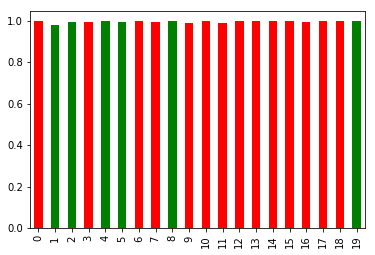

In [10]:
%matplotlib inline
dfsc['probability']=dfsc.apply(lambda x: x['probability_F'] if x['prediction']=='F' else x['probability_T'],axis=1)
dfsc['probability'].plot.bar(color=['r' if x=='F' else 'g' for x in dfsc['prediction']]);